In [51]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

In [52]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [53]:
class SGD(Optimizer):
    def __init__(self, params, eta=1e-2):
        super().__init__(params)
        self.eta = eta

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.eta * p.grad

In [54]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, beta1=0.9, beta2=0.999, eta=0.01):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0

    def step(self):
        with torch.no_grad():
            self.t += 1
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                p -= self.eta * m_hat /(torch.sqrt(v_hat) + self.epsilon)

In [55]:
class AdamW(Optimizer):
    def __init__(self, params, epsilon=1e-8, beta1=0.9, beta2=0.999, eta=1e-3, lbd=0.01):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.lbd = lbd
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0

    def step(self):
        with torch.no_grad():
            self.t += 1
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                p -= self.eta * (m_hat /(torch.sqrt(v_hat) + self.epsilon) + self.lbd * p)

In [56]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer
        self.current_step = 0

    def step(self):
        pass

In [57]:
import math

class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters

        self.base_lr = optimizer.eta

    def step(self):
        self.current_step += 1
        if self.current_step <= self.total_iters:
            factor = self.start_factor + (self.end_factor - self.start_factor) * (self.current_step /self.total_iters)
        else:
            factor = self.end_factor
        self.optimizer.eta = self.base_lr * factor

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.00001
        ):
        super().__init__(optimizer)
        self.optimizer = optimizer
        self.T_max = T_max
        self.eta_min = eta_min
        self.base_lr = optimizer.eta
        self.current_step = 0

    def step(self):
        self.current_step += 1
        cos_term = math.cos(math.pi * (self.current_step % self.T_max)/self.T_max)
        factor = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + cos_term)
        self.optimizer.eta = factor

In [58]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_subset = torch.utils.data.Subset(train_dataset, range(1000))
test_subset = torch.utils.data.Subset(test_dataset, range(200))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=True)

In [59]:
def train_model(model, optimizer, train_loader, test_loader, epochs=30, scheduler=None):
    train_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = nn.functional.cross_entropy(output, target)
            loss.backward()
            if scheduler:
                scheduler.step()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                pred = output.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)
        test_accuracies.append(correct / total)
        if (epoch + 1) % 5 == 0:
          print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Acc: {test_accuracies[-1]:.4f}')

    return train_losses, test_accuracies

In [60]:
print("===Training model with SGD===")
model_sgd = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_sgd = SGD(model_sgd.parameters(), eta=0.01)
losses_sgd, accs_sgd = train_model(model_sgd, optimizer_sgd, train_loader, test_loader)

print("===Training model with Adam===")
model_adam = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_adam = Adam(model_adam.parameters(), eta=0.001)
losses_adam, accs_adam = train_model(model_adam, optimizer_adam, train_loader, test_loader)

print("===Training model with AdamW===")
model_w = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_w = AdamW(model_w.parameters(), eta=0.001, lbd=0.01)
losses_w, accs_w = train_model(model_w, optimizer_w, train_loader, test_loader)

===Training model with SGD===
Epoch 5/30, Loss: 0.6833, Acc: 0.7850
Epoch 10/30, Loss: 0.3416, Acc: 0.8900
Epoch 15/30, Loss: 0.2428, Acc: 0.8850
Epoch 20/30, Loss: 0.1851, Acc: 0.9150
Epoch 25/30, Loss: 0.1422, Acc: 0.8850
Epoch 30/30, Loss: 0.1046, Acc: 0.9150
===Training model with Adam===
Epoch 5/30, Loss: 0.1390, Acc: 0.9000
Epoch 10/30, Loss: 0.0212, Acc: 0.9450
Epoch 15/30, Loss: 0.0060, Acc: 0.9500
Epoch 20/30, Loss: 0.0030, Acc: 0.9500
Epoch 25/30, Loss: 0.0017, Acc: 0.9550
Epoch 30/30, Loss: 0.0012, Acc: 0.9550
===Training model with AdamW===
Epoch 5/30, Loss: 0.1935, Acc: 0.9350
Epoch 10/30, Loss: 0.0437, Acc: 0.9400
Epoch 15/30, Loss: 0.0097, Acc: 0.9400
Epoch 20/30, Loss: 0.0048, Acc: 0.9550
Epoch 25/30, Loss: 0.0029, Acc: 0.9550
Epoch 30/30, Loss: 0.0019, Acc: 0.9550


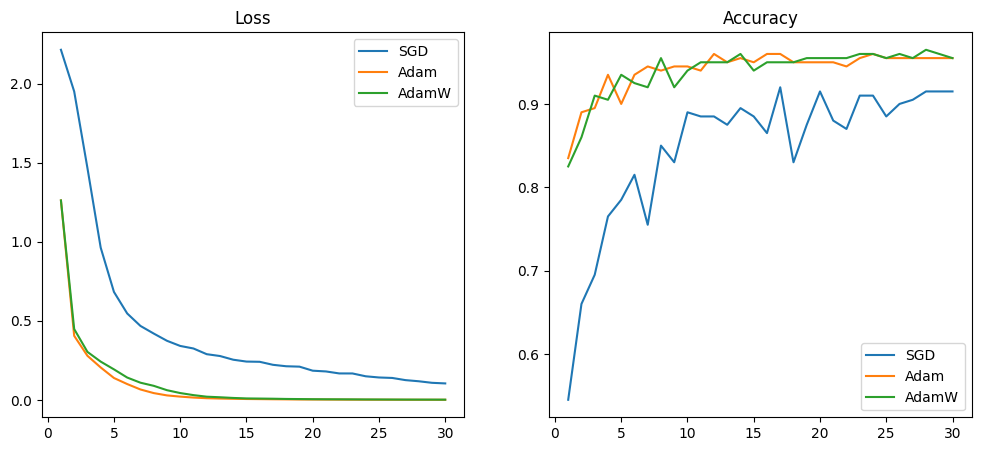

In [61]:
epochs_range = range(1, 31)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, losses_sgd, label='SGD')
plt.plot(epochs_range, losses_adam, label='Adam')
plt.plot(epochs_range, losses_w, label='AdamW')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accs_sgd, label='SGD')
plt.plot(epochs_range, accs_adam, label='Adam')
plt.plot(epochs_range, accs_w, label='AdamW')
plt.title('Accuracy')
plt.legend()
plt.show()

In [62]:
print("===Training model with SGD===")
model_sgd_LR = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_sgd = SGD(model_sgd_LR.parameters(), eta=0.01)
scheduler_sgd = LinearLR(optimizer_sgd)
losses_sgd, accs_sgd = train_model(model_sgd_LR, optimizer_sgd, train_loader, test_loader, scheduler=scheduler_sgd)

print("===Training model with Adam===")
model_adam_LR = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_adam = Adam(model_adam_LR.parameters(), eta=0.001)
scheduler_adam = LinearLR(optimizer_adam)
losses_adam, accs_adam = train_model(model_adam_LR, optimizer_adam, train_loader, test_loader, scheduler=scheduler_adam)

print("===Training model with AdamW===")
model_w_LR = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_w = AdamW(model_w_LR.parameters(), eta=0.001, lbd=0.01)
scheduler_w = LinearLR(optimizer_w)
losses_w, accs_w = train_model(model_w_LR, optimizer_w, train_loader, test_loader, scheduler=scheduler_w)

===Training model with SGD===
Epoch 5/30, Loss: 0.8010, Acc: 0.7450
Epoch 10/30, Loss: 0.3583, Acc: 0.8850
Epoch 15/30, Loss: 0.2552, Acc: 0.9000
Epoch 20/30, Loss: 0.1880, Acc: 0.9000
Epoch 25/30, Loss: 0.1444, Acc: 0.9100
Epoch 30/30, Loss: 0.1062, Acc: 0.9150
===Training model with Adam===
Epoch 5/30, Loss: 0.2295, Acc: 0.9250
Epoch 10/30, Loss: 0.0462, Acc: 0.9350
Epoch 15/30, Loss: 0.0102, Acc: 0.9350
Epoch 20/30, Loss: 0.0040, Acc: 0.9350
Epoch 25/30, Loss: 0.0027, Acc: 0.9400
Epoch 30/30, Loss: 0.0017, Acc: 0.9450
===Training model with AdamW===
Epoch 5/30, Loss: 0.2181, Acc: 0.9150
Epoch 10/30, Loss: 0.0341, Acc: 0.9550
Epoch 15/30, Loss: 0.0108, Acc: 0.9400
Epoch 20/30, Loss: 0.0041, Acc: 0.9400
Epoch 25/30, Loss: 0.0026, Acc: 0.9400
Epoch 30/30, Loss: 0.0016, Acc: 0.9400


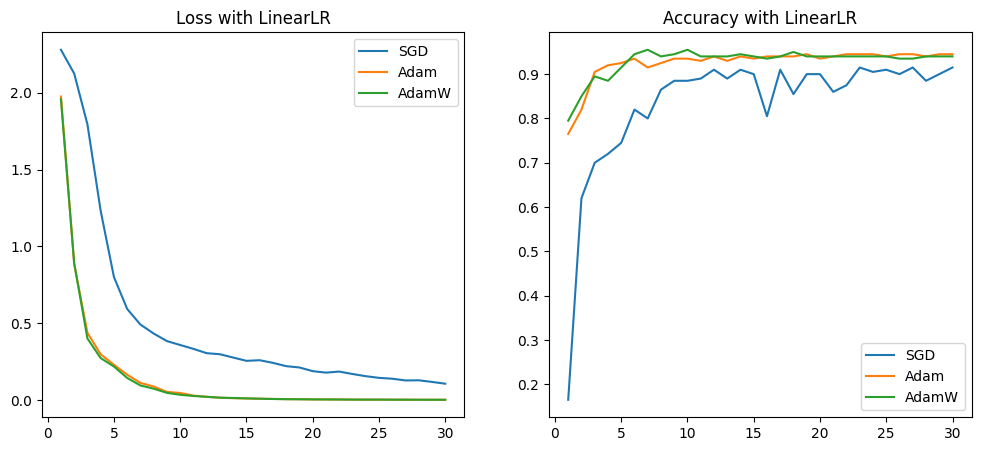

In [63]:
epochs_range = range(1, 31)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, losses_sgd, label='SGD')
plt.plot(epochs_range, losses_adam, label='Adam')
plt.plot(epochs_range, losses_w, label='AdamW')
plt.title('Loss with LinearLR')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accs_sgd, label='SGD')
plt.plot(epochs_range, accs_adam, label='Adam')
plt.plot(epochs_range, accs_w, label='AdamW')
plt.title('Accuracy with LinearLR')
plt.legend()
plt.show()

In [64]:
print("===Training model with SGD===")
model_sgd_CA = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_sgd = SGD(model_sgd_CA.parameters(), eta=0.01)
scheduler_sgd = CosineAnnealing(optimizer_sgd)
losses_sgd, accs_sgd = train_model(model_sgd_CA, optimizer_sgd, train_loader, test_loader, scheduler=scheduler_sgd)

print("===Training model with Adam===")
model_adam_CA = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_adam = Adam(model_adam_CA.parameters(), eta=0.001)
scheduler_adam = CosineAnnealing(optimizer_adam)
losses_adam, accs_adam = train_model(model_adam_CA, optimizer_adam, train_loader, test_loader, scheduler=scheduler_adam)

print("===Training model with AdamW===")
model_w_CA = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(13*13*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
optimizer_w = AdamW(model_w_CA.parameters(), eta=0.001, lbd=0.01)
scheduler_w = CosineAnnealing(optimizer_w)
losses_w, accs_w = train_model(model_w_CA, optimizer_w, train_loader, test_loader, scheduler=scheduler_w)

===Training model with SGD===
Epoch 5/30, Loss: 1.8439, Acc: 0.6700
Epoch 10/30, Loss: 0.7871, Acc: 0.7800
Epoch 15/30, Loss: 0.4511, Acc: 0.8350
Epoch 20/30, Loss: 0.3605, Acc: 0.8350
Epoch 25/30, Loss: 0.2848, Acc: 0.8800
Epoch 30/30, Loss: 0.2444, Acc: 0.9150
===Training model with Adam===
Epoch 5/30, Loss: 0.2868, Acc: 0.9200
Epoch 10/30, Loss: 0.1289, Acc: 0.9250
Epoch 15/30, Loss: 0.0519, Acc: 0.9250
Epoch 20/30, Loss: 0.0256, Acc: 0.9400
Epoch 25/30, Loss: 0.0104, Acc: 0.9400
Epoch 30/30, Loss: 0.0067, Acc: 0.9400
===Training model with AdamW===
Epoch 5/30, Loss: 0.2592, Acc: 0.9200
Epoch 10/30, Loss: 0.0865, Acc: 0.9450
Epoch 15/30, Loss: 0.0523, Acc: 0.9550
Epoch 20/30, Loss: 0.0143, Acc: 0.9550
Epoch 25/30, Loss: 0.0096, Acc: 0.9500
Epoch 30/30, Loss: 0.0048, Acc: 0.9550


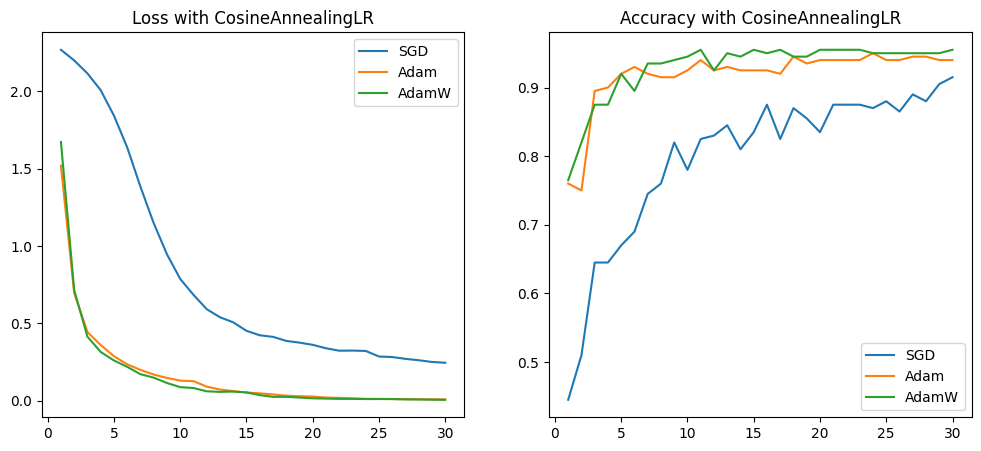

In [66]:
epochs_range = range(1, 31)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, losses_sgd, label='SGD')
plt.plot(epochs_range, losses_adam, label='Adam')
plt.plot(epochs_range, losses_w, label='AdamW')
plt.title('Loss with CosineAnnealingLR')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accs_sgd, label='SGD')
plt.plot(epochs_range, accs_adam, label='Adam')
plt.plot(epochs_range, accs_w, label='AdamW')
plt.title('Accuracy with CosineAnnealingLR')
plt.legend()
plt.show()